# Setup

In [1]:
INPUT_FILES = ("../../data/dataframes/consultation-documents-preprocessed-2024-11-26.parquet",)
DOCUMENT_SOURCES = {
    "fedlex",
    "openparldata",
}
LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
# EMBEDDING_MODEL = "sentence-transformers/distiluse-base-multilingual-cased-v1"
# EMBEDDING_MODEL = "jinaai/jina-embeddings-v2-base-de"
# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"
# EMBEDDING_MODEL = None  # None means BoW + TF-IDF

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 50
IGNORE_TOPICS = {
    # "administration",
    # "communications",
}

DOC_TYPES = {
    # "LETTER",
    "DRAFT",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "VARIOUS_TEXT",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
    None,  # Many PM documents
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271
USE_TEST_SET = False

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [26]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import os

import data_access
import data_transformations
import dotenv
import embeddings

# import itables
import matplotlib.pyplot as plt
import mlflow

# import nltk
import numpy as np
import plotting
import sklearn.metrics
import sklearn.model_selection
import stratified_group_split
import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dotenv.load_dotenv()

True

In [8]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document topics")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_files", INPUT_FILES)
mlflow.log_param("document_sources", sorted(DOCUMENT_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("embedding_model", EMBEDDING_MODEL or "bow-tf-idf")
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

2024/11/26 16:46:13 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/11/26 16:46:13 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Starting run: mysterious-jay-94


''

In [9]:
mlflow.sklearn.autolog()
tqdm.pandas()

# Input data preparation

In [10]:
df_docs = data_access.load_docs(
    INPUT_FILES,
    only_document_sources=DOCUMENT_SOURCES,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../../data/dataframes/consultation-documents-preprocessed-2024-11-26.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at infere

,document_id,consultation_id,consultation_title,consultation_description,consultation_url,consultation_topics,document_type,document_language,document_source,consultation_topics_label_source,organisation_id,organisation_name,doc_text_repr
0,1,1,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,fedlex,manual,41,Bundesamt für Zoll und Grenzsicherheit,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
21,22,2,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://www.demokratis.ch/vernehmlassung/a49pncfq,[communications],DRAFT,de,fedlex,organisation_rule,38,Bundesamt für Kommunikation,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...
42,43,3,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,fedlex,organisation_rule,44,Bundesamt für Energie,2021-… \n \nVerordnung \n \n \n \nVernehmlass...
51,52,3,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,fedlex,organisation_rule,44,Bundesamt für Energie,1 \nRaumplanungsverordnung \n \nVernehmlassung...
54,55,3,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,fedlex,organisation_rule,44,Bundesamt für Energie,2021-… \n \nVerordnung \n \n \n \nVernehmlass...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51926,53052,4830,Änderung der Arbeitslosenversicherungsverordnu...,Im Rahmen der laufenden Revision des AVIG das ...,https://www.demokratis.ch/vernehmlassung/k3h5abdz,"[administration, economics, insurance]",DRAFT,de,fedlex,manual,90,Staatssekretariat für Wirtschaft,«$$e-seal» \n«$$QrCode» \n \nVorentwurf \n \n2...
51947,53073,4931,Anpassungen an den Internationalen Gesundheits...,Die IGV (2005) regeln die internationale Zusam...,https://www.demokratis.ch/vernehmlassung/6ajdyn89,"[foreign_policy, health, security]",DRAFT,de,fedlex,manual,36,Bundesamt für Gesundheit,Vorläufige Übersetzung \n \n \n \nINTERNATION...
51967,53093,4950,Teilrevision des Gesetzes über die Förderung d...,Aufgrund der sich stetig verschlechternden fin...,https://www.demokratis.ch/vernehmlassung/cs8cj72s,"[health, public_finance, social]",DRAFT,de,openparldata,manual,150,Regierung des Kantons Graubünden,AGS [Fundst. od. Gesch.-Nr.] \nGesetz über die...
51982,53108,4951,Revision des Gemeindegesetzes (GG),Gemäss dem geltenden Gemeindegesetz müssen Ein...,https://www.demokratis.ch/vernehmlassung/addxwwjb,"[administration, public_finance]",DRAFT,de,openparldata,manual,166,Regierungsrat des Kantons Zürich,Kanton Zürich \nDirektion der Justiz und des I...


## Create synthetic "documents" from consultation titles, descriptions, org names...

In [11]:
df_consultations_synthetic = data_transformations.create_synthetic_documents_from_consultations(df_docs)
df_consultations_synthetic

,consultation_id,document_source,consultation_topics_label_source,document_id,consultation_url,consultation_topics,document_language,organisation_id,document_type,doc_text_repr
0,1,fedlex,manual,-1,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",de,41,organisation_name,Bundesamt für Zoll und Grenzsicherheit
1,2,fedlex,organisation_rule,-1,https://www.demokratis.ch/vernehmlassung/a49pncfq,[communications],de,38,organisation_name,Bundesamt für Kommunikation
2,3,fedlex,organisation_rule,-1,https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],de,44,organisation_name,Bundesamt für Energie
3,4,fedlex,organisation_rule,-1,https://www.demokratis.ch/vernehmlassung/y9vpep78,[energy],de,44,organisation_name,Bundesamt für Energie
4,5,fedlex,organisation_rule,-1,https://www.demokratis.ch/vernehmlassung/x7985bkz,[economics],de,90,organisation_name,Staatssekretariat für Wirtschaft
...,...,...,...,...,...,...,...,...,...,...
5584,4948,openparldata,manual,-1,https://www.demokratis.ch/vernehmlassung/cve3225h,"[administration, housing, spatial_planning]",de,156,consultation_description,Das amtliche Schätzungswesen soll in Teilen üb...
5585,4949,openparldata,manual,-1,https://www.demokratis.ch/vernehmlassung/wt6b7xbh,"[administration, economics, education]",de,166,consultation_description,In den Richtlinien der Regierungspolitik für d...
5586,4950,openparldata,manual,-1,https://www.demokratis.ch/vernehmlassung/cs8cj72s,"[health, public_finance, social]",de,150,consultation_description,Aufgrund der sich stetig verschlechternden fin...
5587,4951,openparldata,manual,-1,https://www.demokratis.ch/vernehmlassung/addxwwjb,"[administration, public_finance]",de,166,consultation_description,Gemäss dem geltenden Gemeindegesetz müssen Ein...


## Create the input dataframe

In [12]:
df_input, topic_columns = data_transformations.create_input_dataframe(
    df_docs,
    df_consultations_synthetic,
)
df_input

Dropping 22 documents with empty text.


,document_id,consultation_id,consultation_title,consultation_description,consultation_url,consultation_topics,document_type,document_language,document_source,consultation_topics_label_source,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
0,1,1,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,fedlex,manual,...,0,0,0,0,0,1,0,0,0,0
1,22,2,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://www.demokratis.ch/vernehmlassung/a49pncfq,[communications],DRAFT,de,fedlex,organisation_rule,...,0,0,0,0,0,0,0,0,0,0
2,43,3,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,fedlex,organisation_rule,...,0,0,0,0,0,0,0,0,0,0
3,52,3,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,fedlex,organisation_rule,...,0,0,0,0,0,0,0,0,0,0
4,55,3,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://www.demokratis.ch/vernehmlassung/tcspwfam,[energy],DRAFT,de,fedlex,organisation_rule,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8492,-1,4948,NaN,NaN,https://www.demokratis.ch/vernehmlassung/cve3225h,"[administration, housing, spatial_planning]",consultation_description,de,openparldata,manual,...,0,0,0,0,0,0,0,1,0,0
8493,-1,4949,NaN,NaN,https://www.demokratis.ch/vernehmlassung/wt6b7xbh,"[administration, economics, education]",consultation_description,de,openparldata,manual,...,0,0,0,0,0,0,0,0,0,0
8494,-1,4950,NaN,NaN,https://www.demokratis.ch/vernehmlassung/cs8cj72s,"[health, public_finance, social]",consultation_description,de,openparldata,manual,...,0,0,0,1,0,0,1,0,0,0
8495,-1,4951,NaN,NaN,https://www.demokratis.ch/vernehmlassung/addxwwjb,"[administration, public_finance]",consultation_description,de,openparldata,manual,...,0,0,0,1,0,0,0,0,0,0


## Drop underrepresented topics

In [13]:
df_input, topic_columns = data_transformations.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
 topic_culture             18
topic_housing             22
topic_media                8
topic_political_system     4
topic_sports              27
dtype: int64
Dropping these documents without any label: 121


In [14]:
print("Original number of documents:", df_docs.shape[0])
print("df_input size:", df_input.shape[0])

Original number of documents: 2908
df_input size: 8354


## Splits

### Set aside a test set

In [15]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_id"]))

In [16]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (7520, 34)
Test: (834, 34)


In [17]:
assert not set(df_input_train["consultation_id"]) & set(
    df_input_test["consultation_id"]
), "No leakage between train and test sets"

In [18]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

834

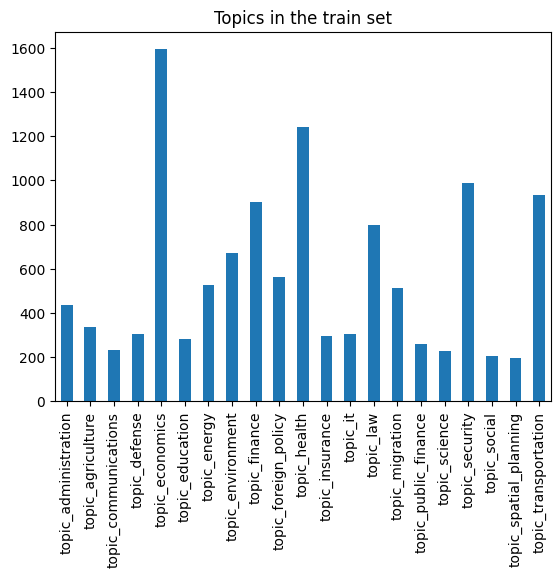

In [19]:
utils.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "figures/topics-counts-train.png",
    title="Topics in the train set",
)

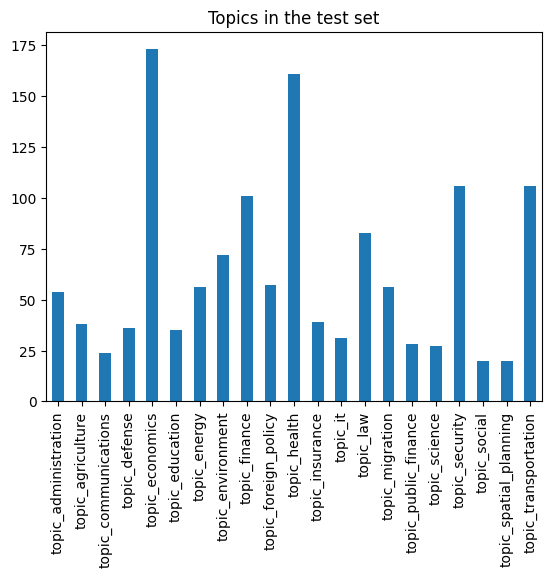

In [20]:
utils.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "figures/topics-counts-test.png",
    title="Topics in the test set",
)

### Prepare a cross-validation splitter

In [21]:
cv_splitter = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [24]:
if EMBEDDING_MODEL is not None:
    embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
    mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

    tokens_train = df_input_train["doc_text_repr"].progress_map(embedding_model.tokenize)
    tokens_test = df_input_test["doc_text_repr"].progress_map(embedding_model.tokenize)

100%|██████████| 834/834 [00:00<00:00, 1231.34it/s]


## Embed

In [27]:
if EMBEDDING_MODEL is not None:
    with embeddings.use_cache(
        embedding_model,
        tqdm=tqdm,
        cache_directory=pathlib.Path().cwd() / ".." / ".." / "data" / "embeddings-cache",
    ) as get_embeddings:
        embeddings_train = get_embeddings(tokens_train.tolist())
        print(embeddings_train.shape)
        embeddings_test = get_embeddings(tokens_test.tolist())
        print(embeddings_test.shape)

Embedding (cached=7519, new=0): 100%|██████████| 7520/7520 [00:04<00:00, 1747.17it/s]


(7520, 3072)


Embedding (cached=833, new=0): 100%|██████████| 834/834 [00:00<00:00, 1472.36it/s]


(834, 3072)


# Classification

In [28]:
if EMBEDDING_MODEL is None:
    X_train = df_input_train["text_repr"].values
    X_test = df_input_test["text_repr"].values
else:
    X_train = embeddings_train
    X_test = embeddings_test

y_train = df_input_train[topic_columns]
y_test = df_input_test[topic_columns]
groups_train = df_input_train["consultation_id"]
groups_test = df_input_test["consultation_id"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (7520, 3072) (7520, 21)
Test (834, 3072) (834, 21)


In [29]:
if EMBEDDING_MODEL is None:
    assert len(LANGUAGES) == 1
    stopwords = nltk.corpus.stopwords.words({"de": "german", "fr": "french", "it": "italian"}[next(iter(LANGUAGES))])

    classifier = make_pipeline(
        CountVectorizer(
            ngram_range=(1, 1),
            # stop_words=stopwords,
        ),
        TfidfTransformer(),
        StandardScaler(with_mean=False),
        # PCA(n_components=300, random_state=RANDOM_STATE),
        MultiOutputClassifier(
            LogisticRegression(max_iter=1000),
            # MLPClassifier(max_iter=1000),
        ),
    )
else:
    classifier = make_pipeline(
        StandardScaler(),
        # PCA(n_components=200, random_state=RANDOM_STATE),
        MultiOutputClassifier(
            LogisticRegression(max_iter=1000),
            # MLPClassifier(max_iter=1000),
            # SGDClassifier(loss="modified_huber", max_iter=1000),
            # GradientBoostingClassifier(random_state=RANDOM_STATE),
        ),
        # OneVsRestClassifier(SVC(kernel="linear")),
    )

classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [30]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])
mlflow.log_param(
    "classifier",
    classifier.named_steps["multioutputclassifier"].estimator.__class__.__name__,
)

'LogisticRegression'

In [91]:
def explained_variance_scorer(pipeline, X, y=None):
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_samples",
    "recall": "recall_samples",
    "f1": "f1_samples",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    groups=groups_train,
    cv=cv_splitter,
    scoring=scoring,
    # return_train_score=True,
)
scores_docs

/Users/vita/Library/Caches/pypoetry/virtualenvs/demokratis-ml-exploration-topics-P4n2QMBD-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Library/Caches/pypoetry/virtualenvs/demokratis-ml-exploration-topics-P4n2QMBD-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Library/Caches/pypoetry/virtualenvs/demokratis-ml-exploration-topics-P4n2QMBD-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Pre

{'fit_time': array([73.38446593, 71.4807508 , 74.33365202, 69.53566194, 68.39820123]),
 'score_time': array([12.62466931, 12.62190795, 12.50856209, 12.11036801, 12.94323397]),
 'test_precision': array([0.72154226, 0.71263602, 0.72891728, 0.7252641 , 0.71164106]),
 'test_recall': array([0.71704775, 0.71824339, 0.73666218, 0.71999326, 0.71286812]),
 'test_f1': array([0.69165786, 0.6868659 , 0.70581868, 0.69387824, 0.68756783]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [92]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({f"{k}_docs": v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.7200 (+/- 0.0068)
Recall:    0.7210 (+/- 0.0082)
F1:        0.6932 (+/- 0.0068)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

Split the training set into 'CV training' and 'CV testing' sets so we still don't have to touch our real test set.

In [93]:
cv_test_splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train, cv_test = stratified_group_split.one_simple_split(
    splitter,
    X=X_train,
    y=y_train,
    groups=groups_train,
)

print("CV train:", cv_train.shapes)
print("CV test:", cv_test.shapes)

CV train: ((6826, 3072), (6826, 21))
CV test: ((694, 3072), (694, 21))


2024/11/26 16:31:11 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2024/11/26 16:34:53 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported


docs: ground truth (694, 21)
docs: predictions (694, 21)
consultations: ground truth (156, 21)
consultations: predictions (156, 21)


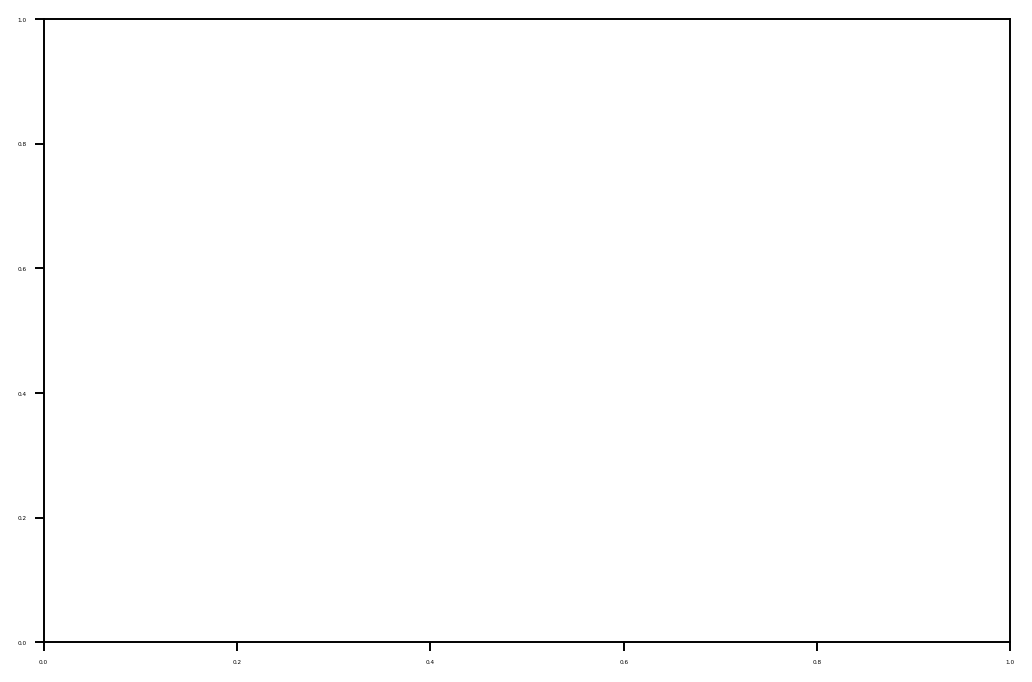

In [94]:
# Train the classifier on the CV train set - documents
classifier.fit(cv_train.X, cv_train.y)
# Get our ground truth - documents
cv_test_ground_truth_docs = cv_test.y
# Predict on the CV test set - documents
cv_test_predictions_docs = classifier.predict(cv_test.X)
assert isinstance(cv_test_predictions_docs, np.ndarray)

# Convert our per-document ground truth to - consultations
cv_test_ground_truth_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_ids=cv_test.groups,
    label_names=topic_columns,
    doc_labels=cv_test_ground_truth_docs,
)
# Convert our per-document predictions to - consultations
cv_test_predictions_consultations = data_transformations.group_document_labels_by_consultation(
    consultation_ids=cv_test.groups,
    label_names=topic_columns,
    doc_labels=cv_test_predictions_docs,
)

print("docs: ground truth", cv_test_ground_truth_docs.shape)
print("docs: predictions", cv_test_predictions_docs.shape)
print("consultations: ground truth", cv_test_ground_truth_consultations.shape)
print("consultations: predictions", cv_test_predictions_consultations.shape)

In [95]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    cv_test_ground_truth_consultations,
    cv_test_predictions_consultations,
    average="samples",
)
scores_consultations = {
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1,
}
mlflow.log_metrics(scores_consultations)
print("Per consultation scores:")
print(f"Precision: {scores_consultations['test_precision']:.4f}")
print(f"Recall:    {scores_consultations['test_recall']:.4f}")
print(f"F1:        {scores_consultations['test_f1']:.4f}")

Per consultation scores:
Precision: 0.8212
Recall:    0.8093
F1:        0.7888


/Users/vita/Library/Caches/pypoetry/virtualenvs/demokratis-ml-exploration-topics-P4n2QMBD-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/Users/vita/Library/Caches/pypoetry/virtualenvs/demokratis-ml-exploration-topics-P4n2QMBD-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


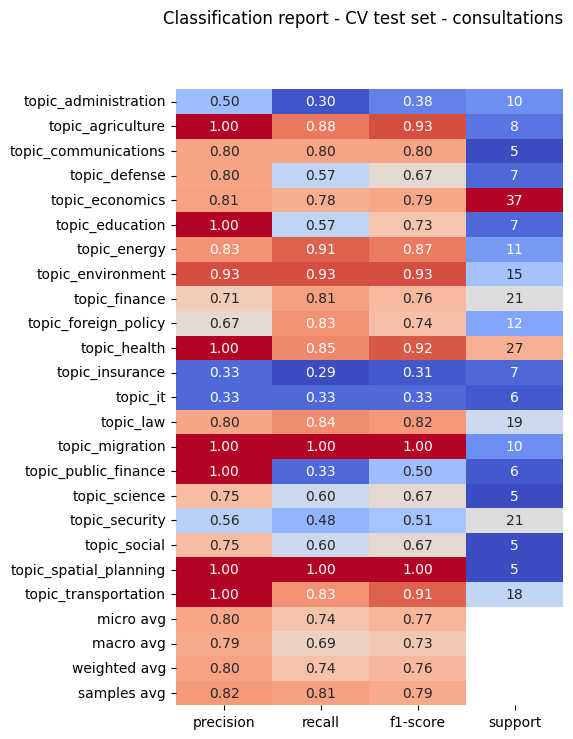

In [96]:
fig = plotting.plot_classification_report_heatmap(
    cv_test_ground_truth_consultations.values,
    cv_test_predictions_consultations.values,
    target_names=topic_columns,
)
fig.suptitle("Classification report - CV test set - consultations")
mlflow.log_figure(fig, "classification_report_heatmap_cv_test.png")
fig

/Users/vita/Library/Caches/pypoetry/virtualenvs/demokratis-ml-exploration-topics-P4n2QMBD-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


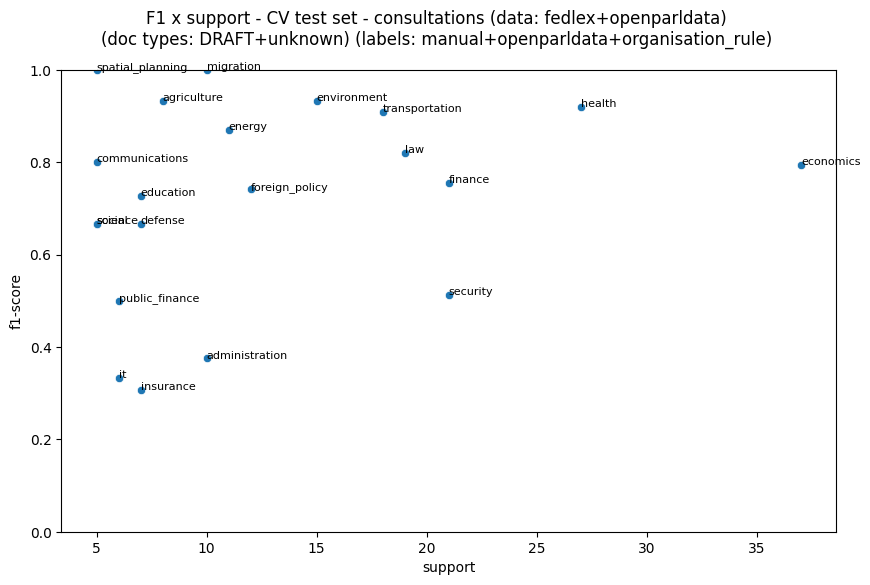

In [97]:
fig = plotting.plot_score_against_support(
    cv_test_ground_truth_consultations.values,
    cv_test_predictions_consultations.values,
    target_names=topic_columns,
)
document_sources = "+".join(sorted(DOCUMENT_SOURCES))
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            f"F1 x support - CV test set - consultations (data: {document_sources})",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
mlflow.log_figure(fig, "classification_report_score_against_support_cv_test.png")
fig

***

## Evaluation on the test set (USE SPARINGLY)

In [98]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    test_ground_truth_consultations = data_transformations.group_document_labels_by_consultation(
        df_input_test["consultation_id"], topic_columns, y_test.values
    )
    test_predictions_consultations = data_transformations.group_document_labels_by_consultation(
        df_input_test["consultation_id"], topic_columns, test_predictions_docs
    )

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)
    print("consultations: ground truth", test_ground_truth_consultations.shape)
    print("consultations: predictions", test_predictions_consultations.shape)

In [99]:
if USE_TEST_SET:
    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        test_ground_truth_consultations,
        test_predictions_consultations,
        average="samples",
    )
    scores_consultations = {
        "test_precision": precision,
        "test_recall": recall,
        "test_f1": f1,
    }
    mlflow.log_metrics(scores_consultations)
    print("Per consultation scores:")
    print(f"Precision: {scores_consultations['test_precision']:.4f}")
    print(f"Recall:    {scores_consultations['test_recall']:.4f}")
    print(f"F1:        {scores_consultations['test_f1']:.4f}")

In [100]:
if USE_TEST_SET:
    fig = plotting.plot_classification_report_heatmap(
        test_ground_truth_consultations,
        test_predictions_consultations,
        target_names=topic_columns,
    )
    mlflow.log_figure(fig, "classification_report_heatmap_test.png")
    display(fig)
    # report = sklearn.metrics.classification_report(
    #     test_ground_truth_consultations,
    #     test_predictions_consultations,
    #     target_names=topic_columns,
    # )
    # mlflow.log_text(report, "classification_report_test.txt")
    # print(report)

In [101]:
if USE_TEST_SET:
    fig, axes = plt.subplots(int(np.ceil(len(topic_columns) / 5)), 5, figsize=(25, 15))
    axes = axes.ravel()

    for i, (cm, topic_name) in enumerate(
        zip(
            sklearn.metrics.multilabel_confusion_matrix(
                test_ground_truth_consultations, test_predictions_consultations
            ),
            topic_columns,
        )
    ):
        disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
        disp.plot(ax=axes[i], values_format=".4g")
        disp.ax_.set_title(topic_name)
        if i < 20:
            disp.ax_.set_xlabel("")
        if i % 5 != 0:
            disp.ax_.set_ylabel("")
        disp.im_.colorbar.remove()

    plt.subplots_adjust(hspace=0.5)
    fig.colorbar(disp.im_, ax=axes)
    mlflow.log_figure(fig, "figures/confusion_matrices.png")
    plt.show()

***

# End MLflow run

In [102]:
mlflow.end_run()

***